In [15]:
import os
import pyvista as pv
import numpy as np
import yaml
import laserscan
# 按照文档，激光雷达的分辨率小于2cm https://hypertech.co.il/wp-content/uploads/2015/12/HDL-64E-Data-Sheet.pdf
grid_dims = [256, 256, 32]
voxel_size = [0.2, 0.2, 0.2] # 0.2m的分辨率
point_cloud_range = [0, -25.6, -2, 51.2, 25.6, 4.4] # 按照JS3C, 只是车辆前方的

# voxel中只有label不需要unpack
def unpack(compressed):
    ''' given a bit encoded voxel grid, make a normal voxel grid out of it.  '''
    uncompressed = np.zeros(compressed.shape[0] * 8, dtype=np.uint8)
    uncompressed[::8] = compressed[:] >> 7 & 1
    uncompressed[1::8] = compressed[:] >> 6 & 1
    uncompressed[2::8] = compressed[:] >> 5 & 1
    uncompressed[3::8] = compressed[:] >> 4 & 1
    uncompressed[4::8] = compressed[:] >> 3 & 1
    uncompressed[5::8] = compressed[:] >> 2 & 1
    uncompressed[6::8] = compressed[:] >> 1 & 1
    uncompressed[7::8] = compressed[:] & 1

    return uncompressed

def _read_SemKITTI(path, dtype, do_unpack):
  bin = np.fromfile(path, dtype=dtype)  # Flattened array
  if do_unpack:
    bin = unpack(bin)
  return bin

def convert_voxel_to_inds(voxels):
    return np.argwhere(voxels > 0)

def convert_bgr_to_rgb(bgr_color_map):
    rgb_color_map = {}
    for key in bgr_color_map:
        rgb_color_map[key] = bgr_color_map[key][::-1]
    return rgb_color_map


In [16]:
# semantic-kitti-api中提供了laserscan.py, semantic-kitti.yaml
velodyne_path =  "./data/velodyne/000000.bin"
label_path = "./data/labels/000000.label"

voxel_bin_path = "./data/voxels/000000.bin" # uint8 就是voxel化之后的点云
voxel_invalid_path = "./data/voxels/000000.invalid" # uint8, the voxel is never directly seen,  not considered in the evaluation
voxel_label_path = "./data/voxels/000000.label" # uint16
voxel_occluded_path = "./data/voxels/000000.occluded" # 


config_file = os.path.join('config/semantic-kitti.yaml')
kitti_config = yaml.safe_load(open(config_file, 'r'))
rgb_color_map = convert_bgr_to_rgb(kitti_config['color_map'])

scan = laserscan.SemLaserScan(nclasses=20, sem_color_dict=rgb_color_map)

scan.open_scan(velodyne_path)  # load point cloud 关键读取代码
scan.open_label(label_path)

scan.colorize()

occupancy = _read_SemKITTI(voxel_bin_path, dtype=np.uint8, do_unpack=True).reshape(grid_dims) # 0 空 or 1 有物体 256*256*32=2097152
invalid = _read_SemKITTI(voxel_invalid_path, dtype=np.uint8, do_unpack=True).reshape(grid_dims) # 0 有效 1 无效
occluded = _read_SemKITTI(voxel_occluded_path, dtype=np.uint8, do_unpack=True).reshape(grid_dims)
voxel_label = _read_SemKITTI(voxel_label_path, dtype=np.uint16, do_unpack=False).reshape(grid_dims) # 这里的label没有remap

/Users/junjiewang/projects/vis_local/.conda/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


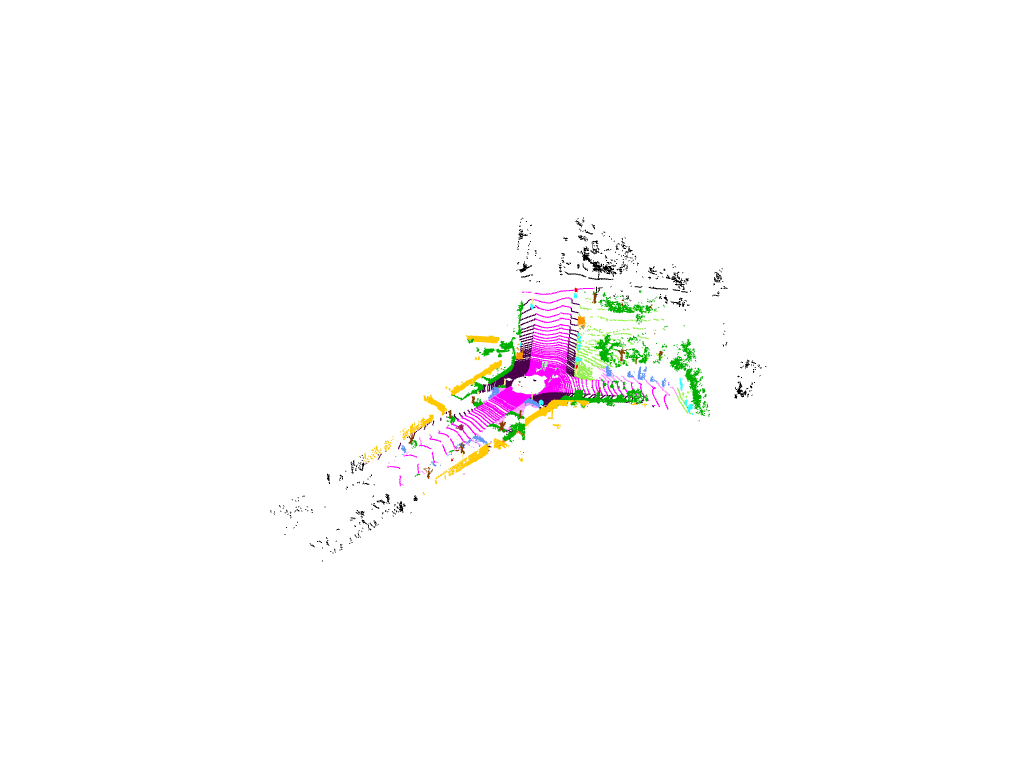

In [17]:
# vis point cloud
point_cloud = pv.PolyData(scan.points)
point_cloud['colors'] = scan.sem_label_color
plotter = pv.Plotter()
plotter.add_mesh(point_cloud, scalars='colors', rgb=True, point_size=1)
plotter.show()

/Users/junjiewang/projects/vis_local/.conda/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


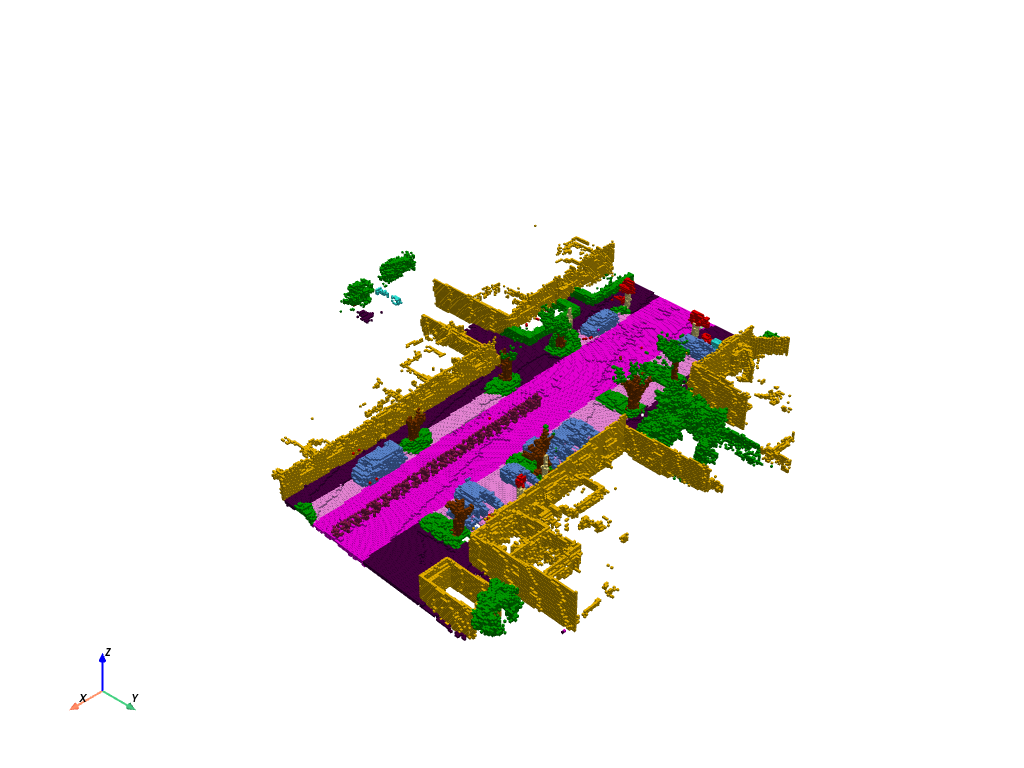

In [18]:
# vis voxel
voxel_inds = convert_voxel_to_inds(voxel_label)
voxel_label = voxel_label[voxel_inds[:, 0], voxel_inds[:, 1], voxel_inds[:, 2]]
voxel_label_color = scan.sem_color_lut[voxel_label]

voxel_inds = voxel_inds + 0.5

pdata = pv.PolyData(voxel_inds)
pdata['colors'] = voxel_label_color

cube = pv.Cube(x_length=0.95, y_length=0.95, z_length=0.95)
pc = pdata.glyph(scale=False, geom=cube, orient=False)
pc.plot(rgb=True, scalars='colors', show_axes=True)

/Users/junjiewang/projects/vis_local/.conda/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


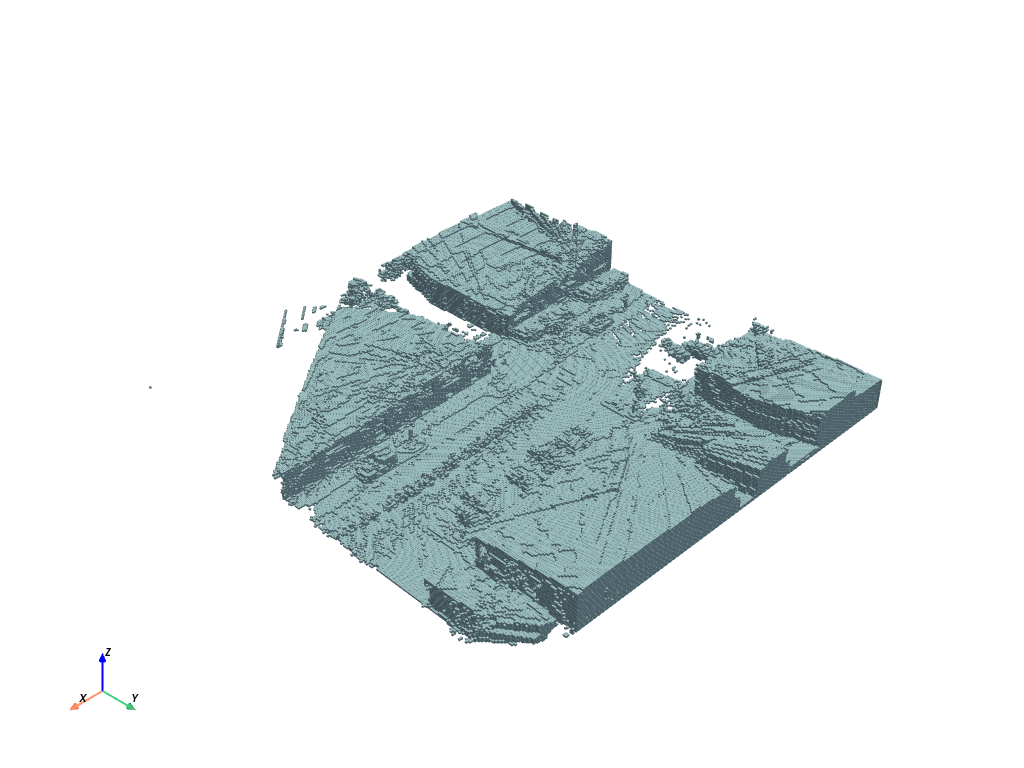

In [19]:
# vis invalid, invalid的位置非常多
invalid_inds = convert_voxel_to_inds(invalid)
invalid = invalid[invalid_inds[:, 0], invalid_inds[:, 1], invalid_inds[:, 2]]

invalid_inds = invalid_inds + 0.5

pdata = pv.PolyData(invalid_inds)

cube = pv.Cube(x_length=0.95, y_length=0.95, z_length=0.95)
pc = pdata.glyph(scale=False, geom=cube, orient=False)
pc.plot(show_axes=True)

/Users/junjiewang/projects/vis_local/.conda/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


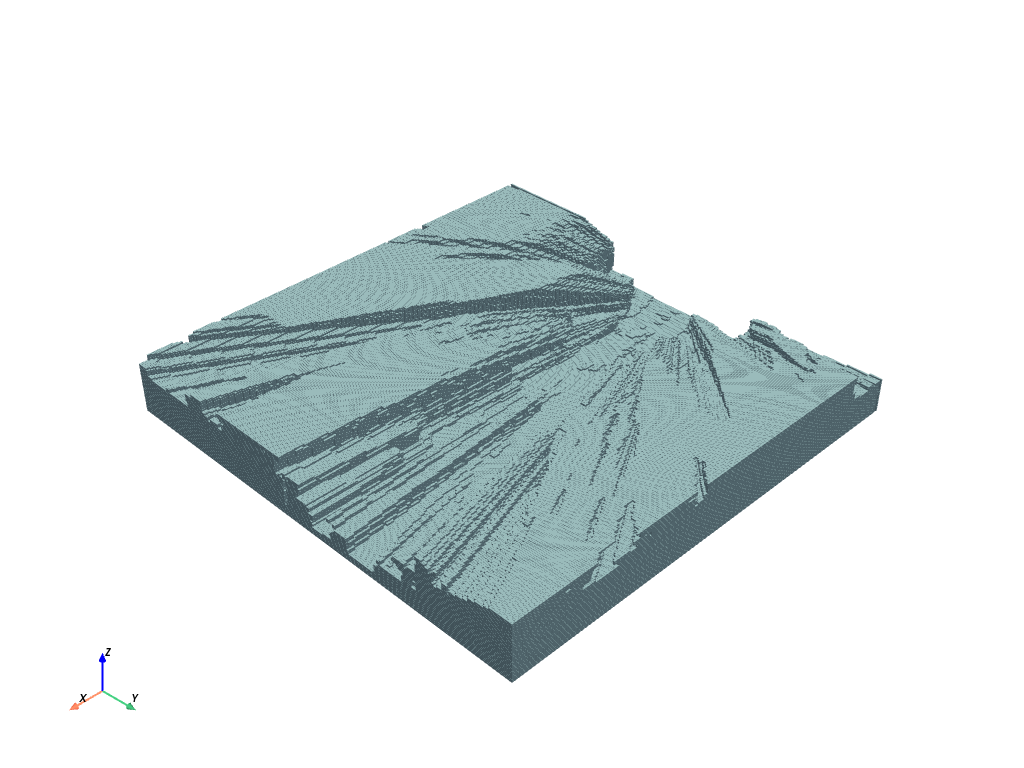

In [20]:
occluded_inds = convert_voxel_to_inds(occluded)
occluded = occluded[occluded_inds[:, 0], occluded_inds[:, 1], occluded_inds[:, 2]]

occluded_inds = occluded_inds + 0.5

pdata = pv.PolyData(occluded_inds)

cube = pv.Cube(x_length=0.95, y_length=0.95, z_length=0.95)
pc = pdata.glyph(scale=False, geom=cube, orient=False)
pc.plot(show_axes=True)